In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'attribution')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
# pth_out = os.path.join(pth, 'figures', 'modeling', 'attribution')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# attributions (training/validation celltypes)
msk_train = (adata.obs.training == 'True')
msk_val = (adata.obs.validation == 'True')
grp = (adata[(msk_train | msk_val)].obs
       .groupby('celltype', observed = True)
       .filter(lambda g: len(g) > 200)
       .groupby('celltype', observed = True))
attr = grp[list(feat_dict.keys())].mean()
z = grp.latent_z.mean()

Top module:  HCAEmbryonicHindlimb


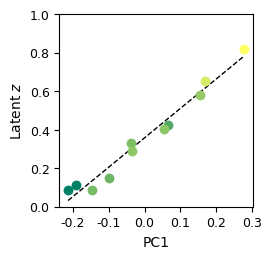

In [56]:
# PCA decomposition
pca = PCA(n_components = 1).fit(attr)
pc1 = pd.Series(pca.transform(attr).flatten(),
                index = attr.index, name = 'PC1')
ix_top = pca.components_[0].argmax()
src_color = attr.columns[ix_top]
print('Top module: ', src_color)

# PC1 vs. latent z (scatter)
s, c = 50, attr[src_color]
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
for i, ix in enumerate(c.argsort()):
    ax.scatter(pc1.iloc[ix],
               z.iloc[ix],
               c = c.iloc[ix],
               vmin = c.min(),
               vmax = c.max(),
               cmap = 'summer',
               zorder = i,
               s = s,
               linewidth = 0)

# least squares line
m, b = np.polyfit(pc1, z, 1)
xx = pc1.sort_values()
yy = m * xx + b
ax.plot(xx, yy,
        c = 'k',
        ls = '--',
        linewidth = 1,
        zorder = 0)

ax.set_ylim(0, 1)
xticks = np.arange(-.2, .31, .1).round(1)
yticks = np.arange(0, 1.1, .2).round(1)
ax.set_xticks(xticks, xticks, size = 9)
ax.set_yticks(yticks, yticks, size = 9)
# ax.set_title('Uncorrelated Modules', size = 10.5)
ax.set_xlabel('PC1', size = 10)
ax.set_ylabel(r'Latent $z$', size = 10)
# fn = os.path.join(pth_out, 'decomposition.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()

In [57]:
# plt.bar(np.arange(attr.shape[1]), pca.components_[0])
# plt.xticks(np.arange(attr.shape[1]), df.loc[attr.columns].Name, rotation = 90)
# plt.show()